In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import skimage.transform

from scipy.ndimage import zoom
from skimage import exposure
import scipy.ndimage as ndi
from sklearn import cluster


from scipy import fftpack
import imageio
from PIL import Image, ImageDraw

In [ ]:
import nibabel as nib

In [ ]:
ct_im = nib.load('/content/drive/MyDrive/kits19/kits19/data/case_00012/imaging.nii.gz')
ct_seg = nib.load('/content/drive/MyDrive/kits19/kits19/data/case_00012/segmentation.nii.gz')
i = 0
pat_path_1 = '/content/drive/MyDrive/kits19/dcm_folder_new/case_00011/slice'+str(i)+'.dcm' ## da usare dopo con i file dcm

In [ ]:
print('Imaging: ')
print(ct_im.shape)
print(ct_im.get_data_dtype())
#print(ct_im.header)

Imaging: 
(89, 512, 512)
float64


In [ ]:
print('Segmentation: ')
mid_slice = int(np.round(ct_seg.shape[0]/2))
print(mid_slice)
print(ct_seg.shape)
print(ct_seg.get_data_dtype())
#print(ct_seg.header)

Segmentation: 
44
(89, 512, 512)
uint8


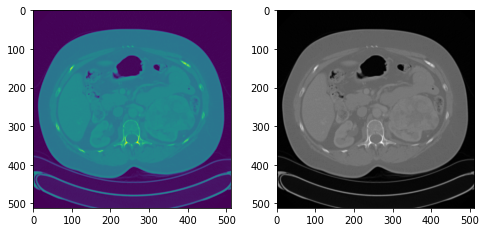

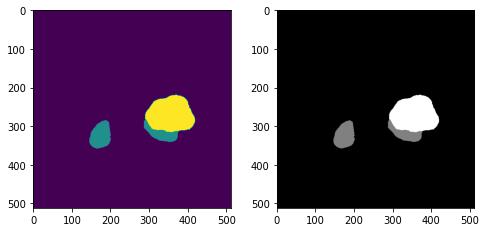

In [ ]:
ct_im1 = ct_im.get_fdata()
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(2,2,1)
imgplot = plt.imshow(ct_im1[mid_slice - 20,:,:]) 
a = fig.add_subplot(2,2,2)
imgplot = plt.imshow(ct_im1[mid_slice - 20,:,:], cmap = 'gray') #in teoria la metà sarebbe 305 ma rimaniamo per ora con 200

ct_seg1 = ct_seg.get_fdata()
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(2,2,3)
imgplot = plt.imshow(ct_seg1[mid_slice - 20,:,:]) #qui metto per forza la metà altrimenti non si vede il tumore
a = fig.add_subplot(2,2,4)
imgplot = plt.imshow(ct_seg1[mid_slice - 20,:,:], cmap = 'gray')

nifti_ext = '.nii.gz'

7
12
17
22
27
32
37
42
47
52
57
62
67
72


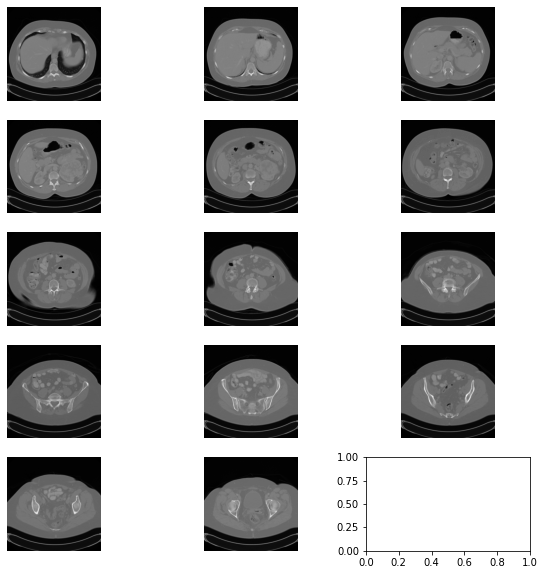

In [ ]:
#series of slices
import math

fig_rows = 5
fig_cols = 3
n_subplots = fig_rows * fig_cols
n_slice = ct_im1.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(np.arange(start_stop, plot_range, step_size)): #np.srange
    axs.flat[idx].imshow(ct_im1[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')
    print(img)


18
23
28
33
38
43
48
53
58


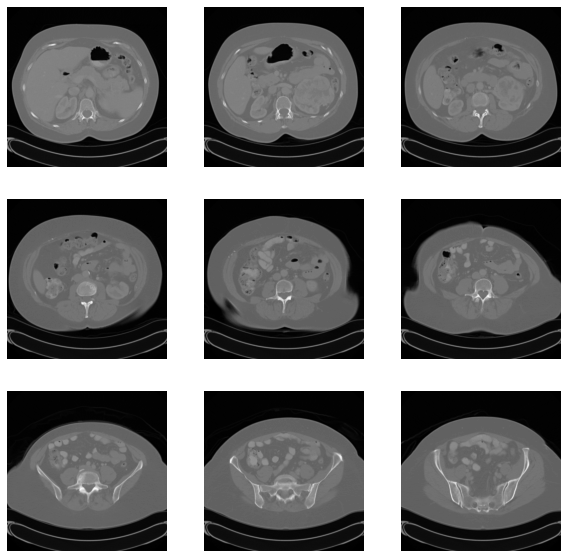

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=[10, 10])

n_slices = np.empty([9,1])
for idx, img in enumerate(np.arange(math.ceil(plot_range / 2) - 4 * step_size, math.ceil(plot_range / 2) - 4 * step_size + 9 * step_size, step_size)):
    axs.flat[idx].imshow(ct_im1[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')
    print(img)

(512, 512)


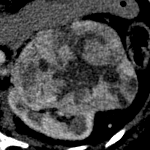

In [ ]:
from google.colab.patches import cv2_imshow

ct_im2 = ct_im1[mid_slice - 20,:,:]
print(ct_im2.shape)
cropped_image = ct_im2[200:350, 280:430] #così seleziono la ROI (256, 256)

# Display cropped image
cv2_imshow(cropped_image)
 
# Save the cropped image
cv2.imwrite("Cropped Image.jpg", cropped_image)
 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#poisson
poisson_noise = np.sqrt(cropped_image) * np.random.normal(0, 1, cropped_image.shape)

pn_img = cropped_image + poisson_noise
pn_img = pn_img.astype ('uint8')

<ipython-input-79-ab4caec0c893>:2: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(cropped_image) * np.random.normal(0, 1, cropped_image.shape)


Text(0.5, 1.0, 'Combined')

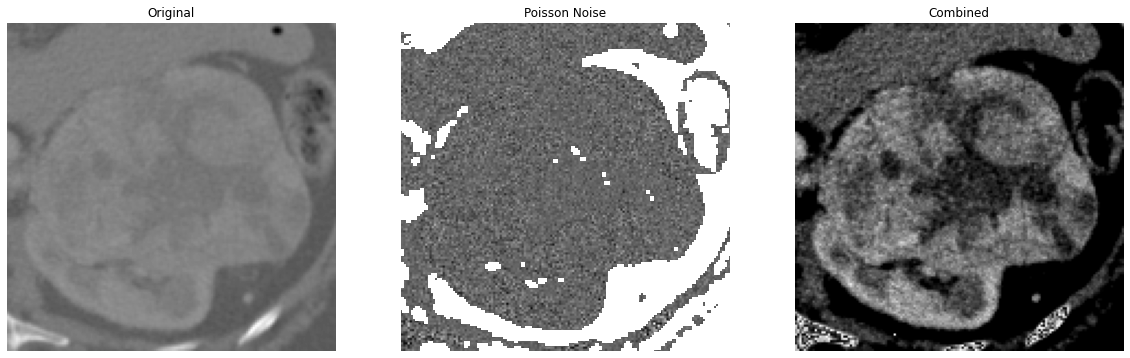

In [ ]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,3,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(poisson_noise,cmap='gray')
plt.axis("off")
plt.title("Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("Combined")

Text(0.5, 1.0, 'After Denoising')

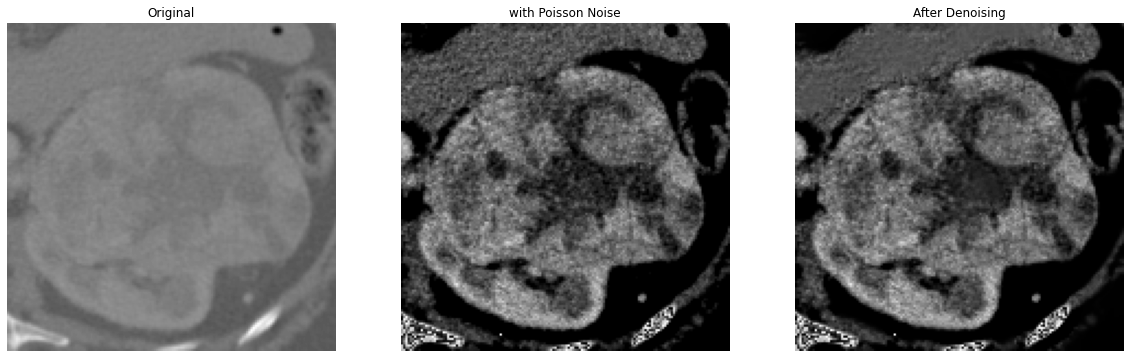

In [ ]:
denoised1=cv2.fastNlMeansDenoising(pn_img,None,10,10)

fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("with Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoised1,cmap='gray')
plt.axis("off")
plt.title("After Denoising")

Filtering


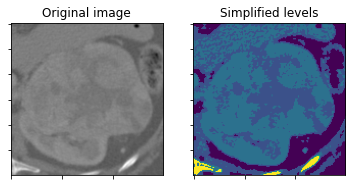

In [ ]:
n_clusters = 4
img = cropped_image.reshape((-1,1))
km = cluster.KMeans(n_clusters=n_clusters)
km.fit(img)
values = km.cluster_centers_.squeeze()
labels = km.labels_

img_segm = np.choose(labels, values)

img_segm.shape = cropped_image.shape


vmin = img.min()
vmax = img.max()

fig = plt.figure(1)
# Plot the original image
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cropped_image,cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Original image')

# Plot the simplified color image
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_segm)
ax2.set_title('Simplified levels')

# Get rid of the tick labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

plt.show()

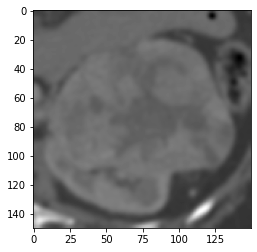

In [ ]:
def test(matrix):
    image1_np = matrix #read_xray2("./CT000000.dcm")
    #fft of image
    fft1 = fftpack.fftshift(fftpack.fft2(image1_np))

    #Create a low pass filter image
    x,y = image1_np.shape[0],image1_np.shape[1]
    #size of circle
    e_x,e_y=50,50
    #create a box
    bbox=((x/2)-(e_x/2),(y/2)-(e_y/2),(x/2)+(e_x/2),(y/2)+(e_y/2))

    low_pass=Image.new("L",(image1_np.shape[0],image1_np.shape[1]),color=0)

    draw1=ImageDraw.Draw(low_pass)
    draw1.ellipse(bbox, fill=1)

    low_pass_np=np.array(low_pass)

    #multiply both the images
    filtered=np.multiply(fft1,low_pass_np)

    #inverse fft
    ifft2 = np.real(fftpack.ifft2(fftpack.ifftshift(filtered)))
    ifft2 = np.maximum(0, np.minimum(ifft2, 255))

    return ifft2

ct_im.PixelData = cv2.GaussianBlur(cropped_image, (7, 7), 0)
plt.imshow(ct_im.PixelData, cmap = 'gray')


In [ ]:
def conv2d(img, filt, padding=0): # padding=0 means we want no padding 
    M, N= img.shape
    m,n=filt.shape
    
    out=np.zeros((M-m+1, N-n+1))
    
    for ii in np.arange (out.shape[0]): 
        for jj in np.arange (out.shape[1]):
            out[ii, jj]= np.sum(filt * img[ii:(ii+m), jj:(jj+n)])
            
    return out

In [ ]:
# We make the filter as made of 1s
filt=np.ones ((5,5))/25 # It is like taking the mean of the image
print (filt)

# We can make another filter that is bigger than the first one 
filt1=np.ones ((10,10))
# Making sure to normalize the kernel 
filt1/= (np.sum(filt1)+1e-6)


[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Text(0.5, 1.0, 'Blurred')

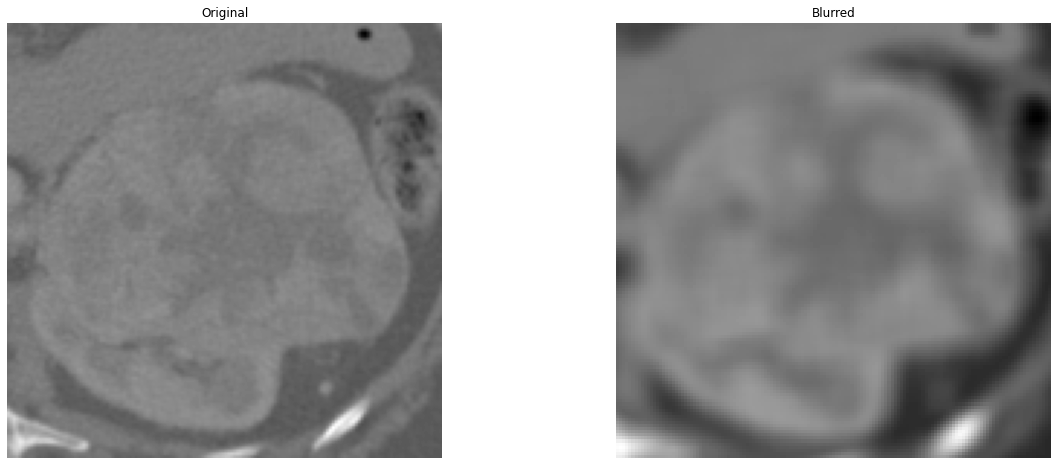

In [ ]:
output = conv2d(cropped_image, filt1)

fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,2,2)
plt.imshow(output,cmap='gray')
plt.axis("off")
plt.title("Blurred")

Gaussian Noise

In [ ]:
gauss_noise=np.zeros((cropped_image.shape[0], cropped_image.shape[1]), dtype=np.float64) #cropped_im o ct_im2
cv2.randn(gauss_noise,128,20)
gauss_noise=(gauss_noise*0.5).astype(np.int16) #img è int16 quindi anche gauss_noise deve esserlo

print(cropped_image.shape)
print(gauss_noise.shape)
print(cropped_image.dtype)
gauss_noise = gauss_noise.astype(np.float64)
print(gauss_noise.dtype) #cambio formato

gn_img=cv2.add(cropped_image, gauss_noise)

(150, 150)
(150, 150)
float64
float64


Text(0.5, 1.0, 'Combined')

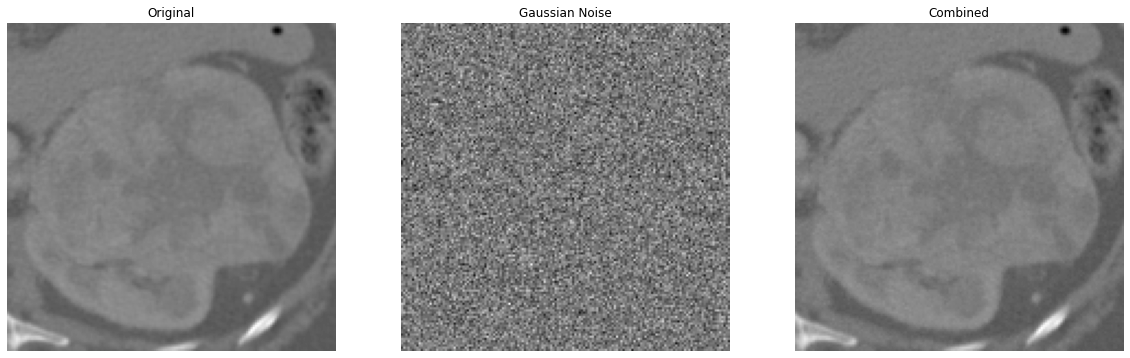

In [ ]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,3,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(gauss_noise,cmap='gray')
plt.axis("off")
plt.title("Gaussian Noise")

fig.add_subplot(1,3,3)
plt.imshow(gn_img,cmap='gray')
plt.axis("off")
plt.title("Combined")

Denoising

In [ ]:
#kernel = [[-1, -2, -1], [-2, 4, -2], [-1, -2, -1]] all the background is white
kernel = [[0, -1, 0], [-1, 5, -1], [0, -1, 0]] #sharpen
kernel = np.asarray (kernel)
kernel = (kernel/16).astype('float32')
blurred20 = cv2.filter2D(gn_img,-1,kernel)

Text(0.5, 1.0, 'Gaussian Filter')

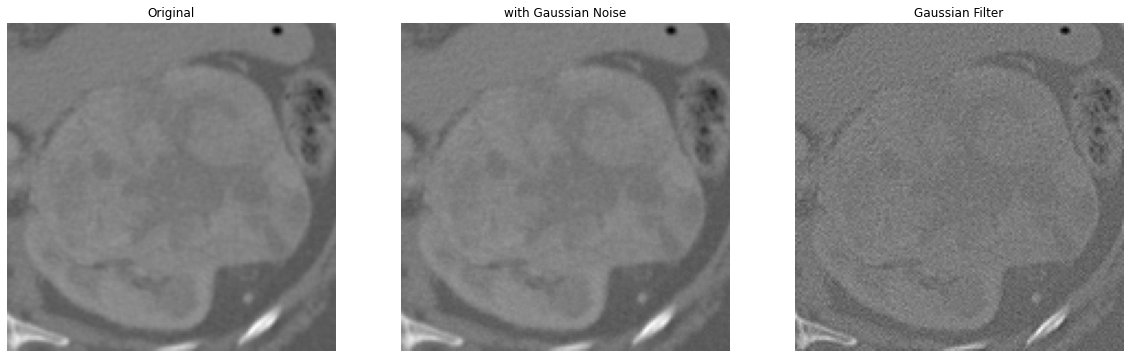

In [ ]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(gn_img,cmap='gray')
plt.axis("off")
plt.title("with Gaussian Noise")

fig.add_subplot(1,3,3)
plt.imshow(blurred20,cmap='gray')
plt.axis("off")
plt.title("Gaussian Filter")

Poisson

In [ ]:
#poisson
poisson_noise = np.sqrt(gn_img) * np.random.normal(0, 1, gn_img.shape)

pn_img = gn_img + poisson_noise
pn_img = pn_img.astype ('uint8')

<ipython-input-91-9838e67e6b72>:2: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(gn_img) * np.random.normal(0, 1, gn_img.shape)


Text(0.5, 1.0, 'Combined')

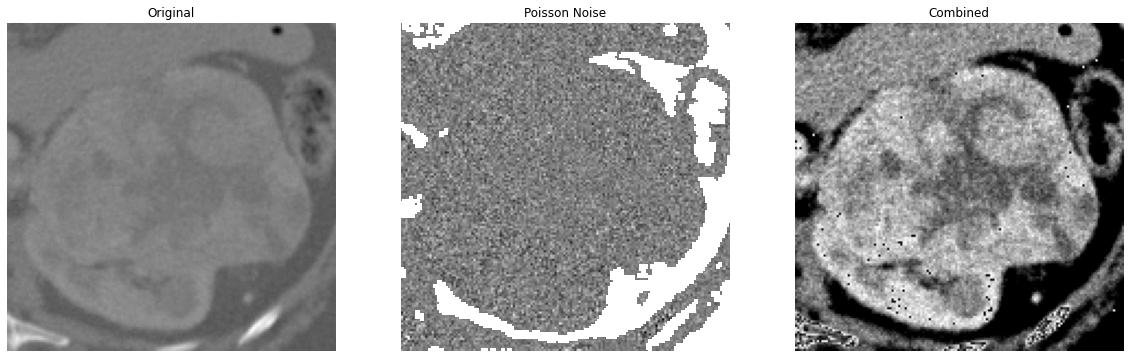

In [ ]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,3,1)
plt.imshow(gn_img,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(poisson_noise,cmap='gray')
plt.axis("off")
plt.title("Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("Combined")

Denoising

Text(0.5, 1.0, 'After Denoising')

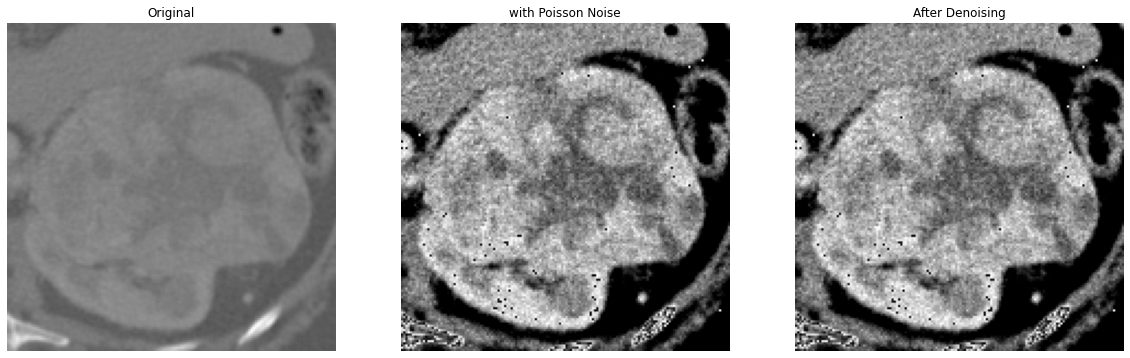

In [ ]:
kernel = np.ones((10,10),np.float32)/25
denoised1=cv2.fastNlMeansDenoising(pn_img,None,10,10)

fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(cropped_image,cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(pn_img,cmap='gray')
plt.axis("off")
plt.title("with Poisson Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoised1,cmap='gray')
plt.axis("off")
plt.title("After Denoising")

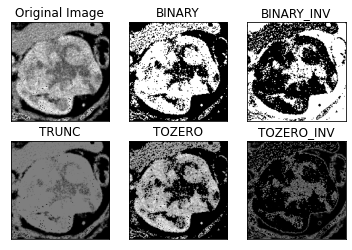

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

ret,thresh1 = cv.threshold(denoised1,127,255,cv.THRESH_BINARY) #binary
ret,thresh2 = cv.threshold(denoised1,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(denoised1,127,255,cv.THRESH_TRUNC) #trunc
ret,thresh4 = cv.threshold(denoised1,127,255,cv.THRESH_TOZERO) #tozero
ret,thresh5 = cv.threshold(denoised1,127,255,cv.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV'] #we can anlyze the BINARY or TOZERO
images = [denoised1, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in np.arange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


Segmentation

Text(0.5, 1.0, 'Image Histogram')

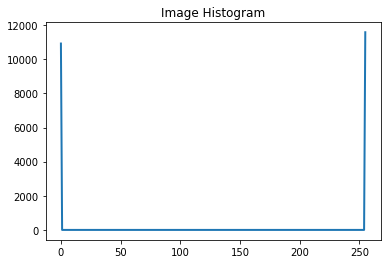

In [ ]:
hist, bins_center = exposure.histogram(thresh1)
plt.plot(bins_center, hist, lw=2)
plt.title('Image Histogram')

In [ ]:
hist1 = np.copy(thresh1)
hist1[hist1 <= 128] = 0
hist1[hist1 > 128] = 255

hist2 = np.copy(thresh1)
hist2[hist2 <= 160] = 0
hist2[hist2 > 160] = 255

Text(0.5, 1.0, 'T = 160')

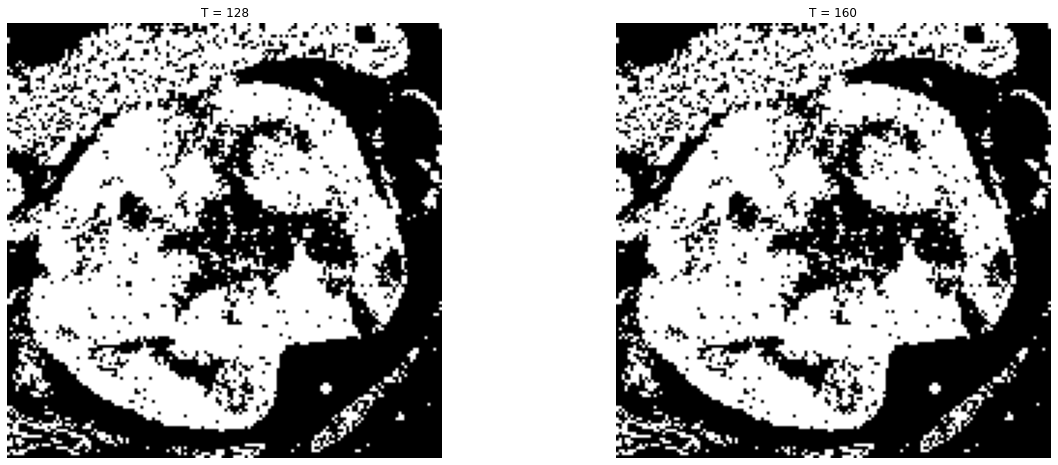

In [ ]:
fig=plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.imshow(hist1, cmap = 'gray') #to take into account
plt.axis("off")
plt.title("T = 128")

fig.add_subplot(1,2,2)
plt.imshow(hist2, cmap = 'gray')
plt.axis("off")
plt.title("T = 160")

PRENDO HIST1 E LA TAGLIO

Median Filter 


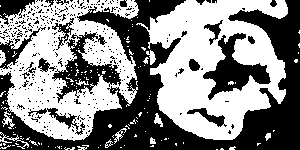

<function destroyAllWindows>

In [ ]:
from google.colab.patches import cv2_imshow
median = cv2.medianBlur(hist2, 5)
compare = np.concatenate((hist2, median), axis=1) #side by side comparison

cv2_imshow(compare)
cv2.waitKey(0)
cv2.destroyAllWindows


PROVO A SEGMENTARE

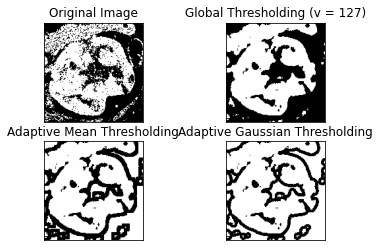

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.medianBlur(hist2.astype('uint8'),5) #medianblur solo con uint8, 
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY) # good
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [hist2, th1, th2, th3]
for i in np.arange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

OTSU 

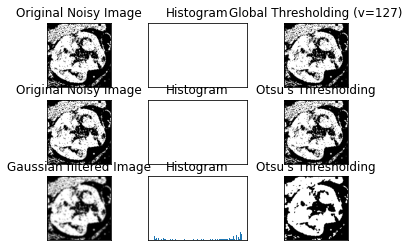

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# global thresholding
ret1,th1 = cv.threshold(hist2.astype('uint8'),127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(hist2.astype('uint8'),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(hist2.astype('uint8'),(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [hist2, 0, th1,
          hist2, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
def dilation(img, kernel):
		kern_center = (kernel.shape[0]//2,kernel.shape[1]//2)
		kernel_ones_count = kernel.sum()
		dilated_img = np.zeros((img.shape[0]+kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1))
		img_shape = img.shape
		
		x_append = np.zeros((img.shape[0],kernel.shape[1]-1))
		img = np.append(img, x_append, axis=1)
		y_append = np.zeros((kernel.shape[0]-1,img.shape[1]))
		img = np.append(img, y_append, axis=0)
		
		for i in np.arange(img_shape[0]):
			for j in np.arange(img_shape[1]):
				i_ = i+kernel.shape[0]
				j_ = j+kernel.shape[1]
				if (kernel*img[i:i_,j:j_]).sum() != 0:
					dilated_img[i+kern_center[0],j+kern_center[1]] = 1

		return(dilated_img[:img_shape[0],:img_shape[1]])

In [ ]:
square3 = np.ones((3, 3), np.uint8) #si possono cambiare i valori
square5 = np.ones((2, 2), np.uint8) 

Text(0.5, 1.0, 'scratch, SE = 5')

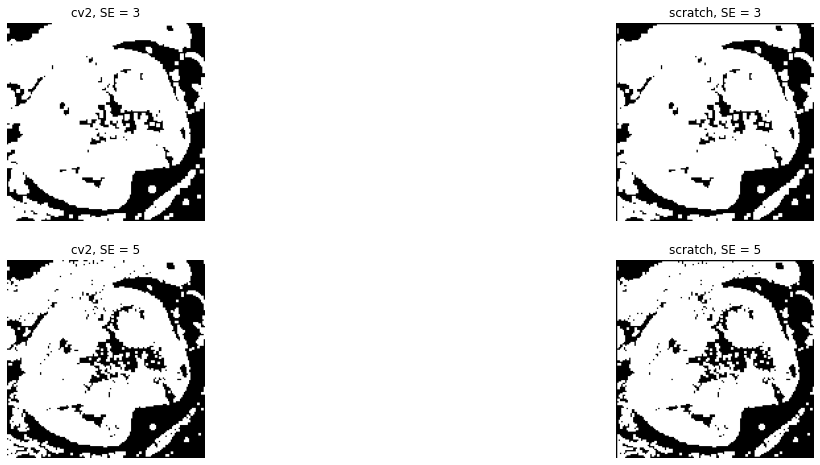

In [ ]:
#ok con la thresh1
dilation_cv3 = cv2.dilate(th1, square3, iterations=1)
dilation_scratch3 = dilation(th1, square3)

dilation_cv5 = cv2.dilate(th1, square5, iterations=1)
dilation_scratch5 = dilation(th1, square5)


fig=plt.figure(figsize=(20,8))

fig.add_subplot(2,2,1)
plt.imshow(dilation_cv3, cmap = 'gray')
plt.axis("off")
plt.title("cv2, SE = 3")

fig.add_subplot(2,2,2)
plt.imshow(dilation_scratch3, cmap = 'gray')
plt.axis("off")
plt.title("scratch, SE = 3")

fig.add_subplot(2,2,3)
plt.imshow(dilation_cv5, cmap = 'gray')
plt.axis("off")
plt.title("cv2, SE = 5")

fig.add_subplot(2,2,4)
plt.imshow(dilation_scratch5, cmap = 'gray')
plt.axis("off")
plt.title("scratch, SE = 5")

In [ ]:
def erosion(img, kernel):
		kern_center = (kernel.shape[0]//2,kernel.shape[1]//2)
		kernel_ones_count = kernel.sum()
		eroded_img = np.zeros((img.shape[0]+kernel.shape[0]-1, img.shape[1]+kernel.shape[1]-1))
		img_shape = img.shape
		

		x_append = np.zeros((img.shape[0],kernel.shape[1]-1))
		img = np.append(img, x_append, axis=1)
		y_append = np.zeros((kernel.shape[0]-1,img.shape[1]))
		img = np.append(img, y_append, axis=0)

		#print(kernel_ones_count)
		
		for i in np.arange(img_shape[0]):
			for j in np.arange(img_shape[1]):
				i_ = i+kernel.shape[0]
				j_ = j+kernel.shape[1]
				if kernel_ones_count == (kernel*img[i:i_,j:j_]).sum()/1:
					eroded_img[i+kern_center[0],j+kern_center[1]] = 1

		return(eroded_img[:img_shape[0],:img_shape[1]])

def closing(img, kernel):
    dilated_img = dilation(img, kernel)
    closed_img = erosion(dilated_img, kernel)

    return(closed_img)

Text(0.5, 1.0, 'scratch, SE = 5')

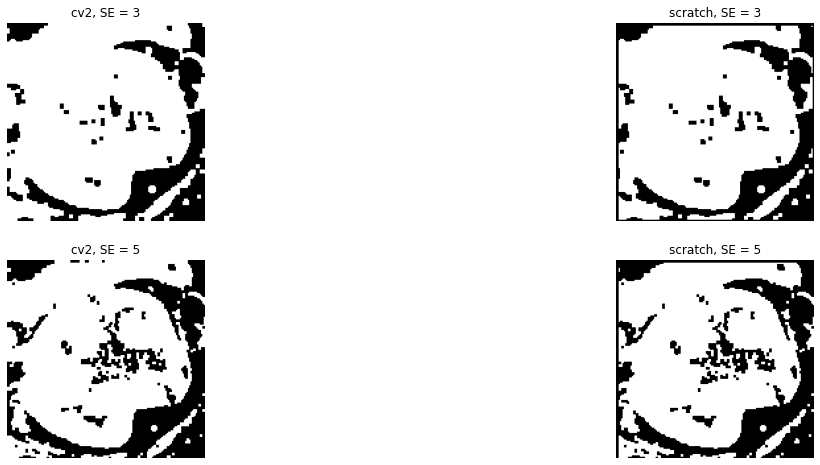

In [ ]:
closing_cv3 = cv2.morphologyEx(dilation_cv3, cv2.MORPH_CLOSE, square3, iterations=1) #metto dilation al posto di img al primo elemento
closing_scratch3 = closing(dilation_scratch3, square3)

closing_cv5 = cv2.morphologyEx(dilation_cv5, cv2.MORPH_CLOSE, square5, iterations=1)
closing_scratch5 = closing(dilation_scratch5, square5)

fig=plt.figure(figsize=(20,8))

fig.add_subplot(2,2,1)
plt.imshow(closing_cv3, cmap = 'gray')
plt.axis("off")
plt.title("cv2, SE = 3")

fig.add_subplot(2,2,2)
plt.imshow(closing_scratch3, cmap = 'gray')
plt.axis("off")
plt.title("scratch, SE = 3")

fig.add_subplot(2,2,3)
plt.imshow(closing_cv5, cmap = 'gray')
plt.axis("off")
plt.title("cv2, SE = 5")

fig.add_subplot(2,2,4)
plt.imshow(closing_scratch5, cmap = 'gray')
plt.axis("off")
plt.title("scratch, SE = 5")


dilation

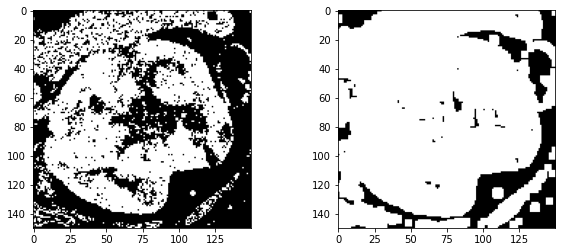

In [ ]:
# devo oscurare la parte intorno il rene

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(hist2,kernel,iterations = 1)

fig=plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.imshow(hist2, cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(dilation, cmap='gray')

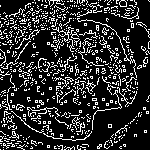

-1

In [ ]:
#seleziono gli edges

edged=cv2.Canny(hist2,30,200)
cv2_imshow(edged)
cv2.waitKey(0)

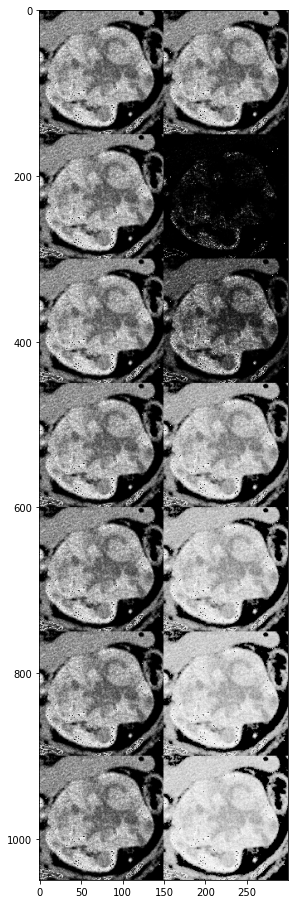

In [ ]:
corr_imgs = np.hstack([pn_img, pn_img])

for gamma in np.arange(0.0, 3.5, 0.5):
  # ignore when gamma is 1 (there will be no change to the image)
  if gamma == 1:
    continue
    
  gamma = gamma if gamma > 0 else 0.1
  invGamma = 1.0 / gamma
  
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  #print (table)
  # apply gamma correction using the lookup table
  adjusted = cv2.LUT(pn_img, table)
  corr_imgs_1 = np.hstack([pn_img, adjusted])
  corr_imgs = np.vstack ([corr_imgs, corr_imgs_1])

fig = plt.figure(figsize=(16,16))
plt.imshow(corr_imgs, cmap = 'gray')